# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [152]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from tqdm import tqdm

%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [224]:
%run hw_framework.ipynb

/home/ummagumma/.local/lib/python3.10/site-packages/IPython/core/magic.py:187: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 1.12 s, sys: 58.9 ms, total: 1.17 s
Wall time: 149 ms
CPU times: user 78.1 ms, sys: 5.38 ms, total: 83.4 ms
Wall time: 10.5 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [6]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [135]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n, 1), 2), axis=0))

best_possible_mse: [0.03968399]


In [139]:
def train(model, criterion, optimizer, X, Y, epochs=5):
    history = []
    grads = []
    grad_means_l = []

    for i in tqdm(range(epochs)):
        for x, y_true in loader(X, Y, batch_size):
#             x_ = normalize_x(x)
#             y_true_oh = to_one_hot(y_true, 10)
            y_pred = model.forward(x)
#             print(y_pred, y_true)
            loss = criterion.forward(y_pred, y_true)

            grad = criterion.backward(y_pred, y_true)
            model.backward(x, grad)
            
#             g = clip_grad(model.grad_parameters(), 1.0)
#             grads.append(g)
#             grad_means_l.append(grad_means(model.grad_parameters()))

            # обновляем веса
            optimizer.step()

#             print(loss)
            history.append(loss)

    plt.title("Training loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(history, 'b')
    plt.show()
    
#     plt.title("Gradient mean")
#     plt.xlabel("iteration")
#     plt.ylabel("grad mean")
#     plt.plot(grads, 'b')
#     plt.show()
    
#     plt.plot(grad_means_l)
#     plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 197.40it/s]


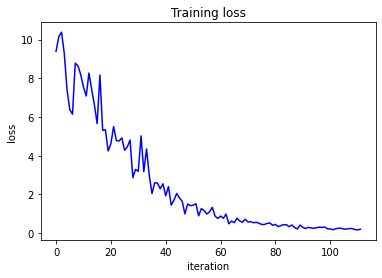

In [149]:
epochs = 50
batch_size = 64
learning_rate = 1e-3

model = Sequential(
    Linear(10, 1),
#     ReLU(),
#     Linear(5, 1),
)

criterion = MSE()
optimizer = Momentum(model.parameters())
train(model, criterion, optimizer, X, Y, epochs=7)

### MNIST

In [239]:
dataset = fetch_openml(name='mnist_784')
X = dataset.data.to_numpy()[:3000]
Y = dataset.target.to_numpy().astype(np.float64)[:3000]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

### Модель

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [10]:
def to_one_hot(x, n_classes):
    out = np.zeros((x.shape[0], n_classes))
    out[np.arange(x.shape[0]),x.astype(np.int32)] = 1
    return out

def normalize_x(x):
    return (x - 128) / 128

In [202]:
def evaluate(model, X, Y):
    model.eval()
    trues = []
    preds = []    
    for x, y_true in loader(X, Y, batch_size):
        x_ = normalize_x(x)
        y_pred = model.forward(x_).argmax(axis=1)
        trues.extend(y_true)
        preds.extend(y_pred)
        
    return classification_report(trues, preds, digits=5)

In [12]:
def grad_means(grads):
    return list(map(lambda x: float(x.mean()), grads))

In [223]:
def train(model, criterion, optimizer, X, Y,
          scheduler=None,
          epochs = 5,
          batch_size = 128,
          learning_rate = 1e-3):
    history = []
    grads = []
    grad_means_l = []
    lrs = []

    for i in tqdm(range(epochs)):
        model.train()
        for x, y_true in loader(X, Y, batch_size):

            x_ = normalize_x(x)
            y_true_oh = to_one_hot(y_true, 10)
            y_pred = model.forward(x_)
            loss = criterion.forward(y_pred, y_true_oh)

            grad = criterion.backward(y_pred, y_true_oh)
            model.backward(x_, grad)
            
#             g = clip_grad(model.grad_parameters(), 1.0)
#             grads.append(g)
            grad_means_l.append(grad_means(model.grad_parameters()))

            # обновляем веса
            optimizer.step()
            lrs.append(optimizer.lr)

            history.append(loss)
            
        print(weight_norm(model.parameters()))
        if scheduler is not None:
            scheduler.step(i)

    plt.title("Training loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(history, 'b')
    plt.show()
    
#     plt.title("Gradient mean")
#     plt.xlabel("iteration")
#     plt.ylabel("grad mean")
#     plt.plot(grads, 'b')
#     plt.show()
    
    plt.plot(lrs)
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.22s/it]


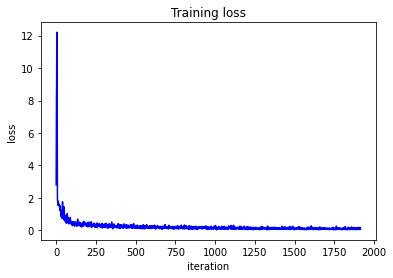

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2118
         1.0       0.98      0.99      0.98      2360
         2.0       0.96      0.96      0.96      2126
         3.0       0.96      0.96      0.96      2150
         4.0       0.95      0.97      0.96      2020
         5.0       0.96      0.95      0.96      1829
         6.0       0.98      0.97      0.98      2087
         7.0       0.93      0.98      0.95      2157
         8.0       0.98      0.92      0.95      2039
         9.0       0.95      0.94      0.95      2114

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000



In [86]:
# model = Sequential(
#     Linear(784, 256),
#     ReLU(),
#     Linear(256, 64),
#     ReLU(),
#     Linear(64, 16),
#     ReLU(),
#     Linear(16, 10),
#     SoftMax()
# )
model = Sequential(
    Linear(784, 300),
    ReLU(),
    Linear(300, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = SGD(model.parameters(), lr=1e-3)

train(model, criterion, optimizer, x_train, y_train)
print(evaluate(model, x_test, y_test))

### Try different optimizers

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:07<00:00,  4.94s/it]


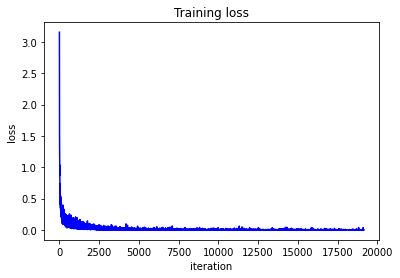

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2108
         1.0       0.99      0.99      0.99      2420
         2.0       0.97      0.97      0.97      2066
         3.0       0.98      0.97      0.97      2111
         4.0       0.99      0.97      0.98      2029
         5.0       0.97      0.97      0.97      1825
         6.0       0.97      0.99      0.98      2071
         7.0       0.98      0.99      0.98      2242
         8.0       0.97      0.97      0.97      1992
         9.0       0.97      0.97      0.97      2136

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [157]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = SGD(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=50)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.19s/it]


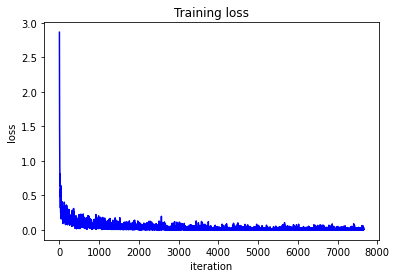

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2108
         1.0       0.99      0.99      0.99      2420
         2.0       0.97      0.98      0.98      2066
         3.0       0.98      0.98      0.98      2111
         4.0       0.98      0.98      0.98      2029
         5.0       0.98      0.96      0.97      1825
         6.0       0.97      0.99      0.98      2071
         7.0       0.98      0.98      0.98      2242
         8.0       0.97      0.98      0.98      1992
         9.0       0.98      0.96      0.97      2136

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [158]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Momentum(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=20)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [03:08<00:00,  3.15s/it]


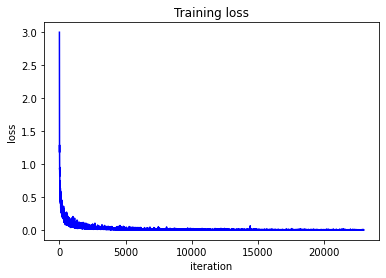

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2108
         1.0       0.99      0.99      0.99      2420
         2.0       0.97      0.98      0.97      2066
         3.0       0.98      0.98      0.98      2111
         4.0       0.98      0.98      0.98      2029
         5.0       0.97      0.98      0.97      1825
         6.0       0.98      0.98      0.98      2071
         7.0       0.98      0.98      0.98      2242
         8.0       0.98      0.98      0.98      1992
         9.0       0.98      0.97      0.97      2136

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [159]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = AdaGrad(model.parameters(), lr=0.01)

train(model, criterion, optimizer, x_train, y_train, epochs=60)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:26<00:00,  4.88s/it]


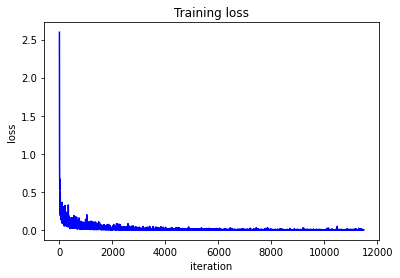

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2118
         1.0       0.99      0.99      0.99      2360
         2.0       0.98      0.98      0.98      2126
         3.0       0.98      0.98      0.98      2150
         4.0       0.98      0.99      0.98      2020
         5.0       0.98      0.98      0.98      1829
         6.0       0.99      0.99      0.99      2087
         7.0       0.97      0.98      0.98      2157
         8.0       0.98      0.98      0.98      2039
         9.0       0.98      0.97      0.98      2114

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [92]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = AdaGrad(model.parameters(), lr=0.05)

train(model, criterion, optimizer, x_train, y_train, epochs=30)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:31<00:00,  5.07s/it]


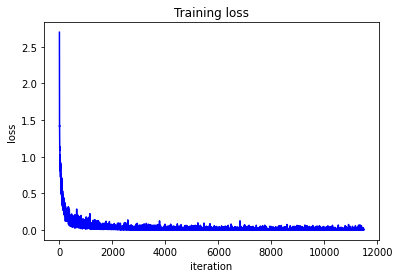

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2118
         1.0       0.98      0.99      0.99      2360
         2.0       0.98      0.98      0.98      2126
         3.0       0.99      0.96      0.97      2150
         4.0       0.97      0.98      0.98      2020
         5.0       0.96      0.98      0.97      1829
         6.0       0.99      0.99      0.99      2087
         7.0       0.97      0.98      0.98      2157
         8.0       0.98      0.97      0.97      2039
         9.0       0.98      0.97      0.97      2114

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [101]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = RMSProp(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=30)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:41<00:00,  5.62s/it]


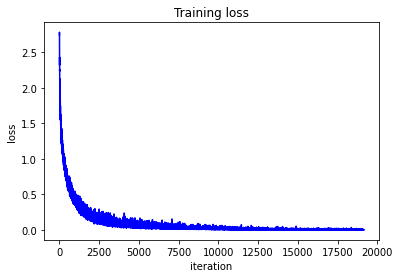

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2118
         1.0       0.98      0.99      0.99      2360
         2.0       0.97      0.97      0.97      2126
         3.0       0.98      0.97      0.97      2150
         4.0       0.98      0.98      0.98      2020
         5.0       0.97      0.97      0.97      1829
         6.0       0.99      0.98      0.98      2087
         7.0       0.98      0.98      0.98      2157
         8.0       0.97      0.97      0.97      2039
         9.0       0.97      0.96      0.97      2114

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [104]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = AdaDelta(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=50)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:34<00:00,  5.48s/it]


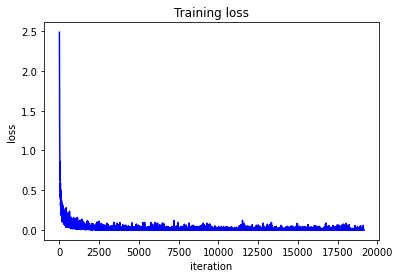

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2118
         1.0       0.99      0.99      0.99      2360
         2.0       0.98      0.98      0.98      2126
         3.0       0.99      0.97      0.98      2150
         4.0       0.98      0.98      0.98      2020
         5.0       0.98      0.98      0.98      1829
         6.0       0.99      0.98      0.99      2087
         7.0       0.98      0.98      0.98      2157
         8.0       0.97      0.98      0.98      2039
         9.0       0.98      0.98      0.98      2114

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



In [134]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=50)
print(evaluate(model, x_test, y_test))

### Add Dropout

  4%|██▋                                                                 | 1/25 [00:00<00:04,  5.89it/s]

32.30766951618413


  8%|█████▍                                                              | 2/25 [00:00<00:05,  4.49it/s]

32.72599544398609


 16%|██████████▉                                                         | 4/25 [00:00<00:04,  4.47it/s]

33.02205970546695
33.24989055627002


 24%|████████████████▎                                                   | 6/25 [00:01<00:03,  5.42it/s]

33.43679544146655
33.5843731112834


 32%|█████████████████████▊                                              | 8/25 [00:01<00:03,  5.48it/s]

33.70271901215323
33.798123035320266


 40%|██████████████████████████▊                                        | 10/25 [00:01<00:02,  5.52it/s]

33.873993872940744
33.93549019366898


 48%|████████████████████████████████▏                                  | 12/25 [00:02<00:02,  5.78it/s]

33.99210257190634
34.03963887801902


 52%|██████████████████████████████████▊                                | 13/25 [00:02<00:01,  6.03it/s]

34.076160204185214


 56%|█████████████████████████████████████▌                             | 14/25 [00:02<00:03,  3.47it/s]

34.10572585489627


 60%|████████████████████████████████████████▏                          | 15/25 [00:04<00:05,  1.94it/s]

34.136828371826745


 68%|█████████████████████████████████████████████▌                     | 17/25 [00:04<00:03,  2.35it/s]

34.1610891086026
34.18998635376648


 76%|██████████████████████████████████████████████████▉                | 19/25 [00:05<00:01,  3.60it/s]

34.217204057440796
34.24060207621052


 84%|████████████████████████████████████████████████████████▎          | 21/25 [00:05<00:00,  4.82it/s]

34.26057140156491
34.28065423505371


 92%|█████████████████████████████████████████████████████████████▋     | 23/25 [00:05<00:00,  5.72it/s]

34.29923686677233
34.317853914266095


100%|███████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.22it/s]

34.33498205801526
34.35690286135377


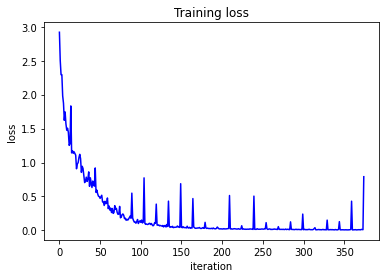

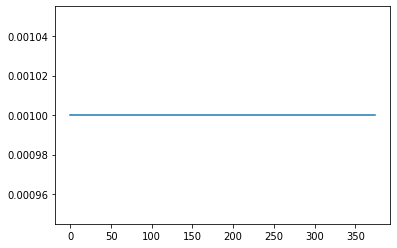

              precision    recall  f1-score   support

         0.0    0.97581   0.99180   0.98374       122
         1.0    0.93985   0.98425   0.96154       127
         2.0    0.91525   0.88525   0.90000       122
         3.0    0.96000   0.87591   0.91603       137
         4.0    0.88550   0.94309   0.91339       123
         5.0    0.91489   0.88660   0.90052        97
         6.0    0.91736   0.96522   0.94068       115
         7.0    0.92517   0.95775   0.94118       142
         8.0    0.96907   0.85455   0.90821       110
         9.0    0.89091   0.93333   0.91163       105

    accuracy                        0.92917      1200
   macro avg    0.92938   0.92777   0.92769      1200
weighted avg    0.93022   0.92917   0.92881      1200



In [240]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=25)
print(evaluate(model, x_test, y_test))

  3%|█▉                                                                  | 1/35 [00:00<00:07,  4.33it/s]

36.66283947862665
42.149144344986865

  6%|███▉                                                                | 2/35 [00:00<00:07,  4.69it/s]

  9%|█████▊                                                              | 3/35 [00:02<00:28,  1.14it/s]

44.51792062503417


 11%|███████▊                                                            | 4/35 [00:02<00:25,  1.23it/s]

45.88575996809063


 14%|█████████▋                                                          | 5/35 [00:03<00:18,  1.60it/s]

47.075790341848226


 17%|███████████▋                                                        | 6/35 [00:03<00:14,  2.05it/s]

48.32038043755868


 23%|███████████████▌                                                    | 8/35 [00:03<00:09,  2.98it/s]

49.631639162158386
51.07497157615271


 29%|███████████████████▏                                               | 10/35 [00:04<00:06,  3.89it/s]

52.47492923947099
53.8107810827798


 34%|██████████████████████▉                                            | 12/35 [00:04<00:05,  4.51it/s]

55.1104878300524
56.404559200351365


 37%|████████████████████████▉                                          | 13/35 [00:05<00:10,  2.16it/s]

57.665584615074586


 43%|████████████████████████████▋                                      | 15/35 [00:06<00:10,  1.85it/s]

58.94125574543822
60.19797658614721


 46%|██████████████████████████████▋                                    | 16/35 [00:07<00:08,  2.30it/s]

61.30234790955922


 49%|████████████████████████████████▌                                  | 17/35 [00:07<00:07,  2.37it/s]

62.330827598349714


 51%|██████████████████████████████████▍                                | 18/35 [00:07<00:06,  2.67it/s]

63.34726970790847


 57%|██████████████████████████████████████▎                            | 20/35 [00:08<00:04,  3.51it/s]

64.33393652518143
65.21745311156538


 63%|██████████████████████████████████████████                         | 22/35 [00:08<00:03,  4.11it/s]

66.10260704360053
67.00558451354046


 66%|████████████████████████████████████████████                       | 23/35 [00:09<00:05,  2.33it/s]

67.8699818998031


 71%|███████████████████████████████████████████████▊                   | 25/35 [00:10<00:05,  1.83it/s]

68.65733253654274
69.37603695892152


 77%|███████████████████████████████████████████████████▋               | 27/35 [00:11<00:02,  2.78it/s]

70.14371733427512
70.87081159620115


 83%|███████████████████████████████████████████████████████▌           | 29/35 [00:11<00:01,  3.66it/s]

71.74456238004923
72.50407655809785


 89%|███████████████████████████████████████████████████████████▎       | 31/35 [00:12<00:00,  4.01it/s]

73.15537139843241
73.813892596217


 94%|███████████████████████████████████████████████████████████████▏   | 33/35 [00:12<00:00,  4.55it/s]

74.47619107453706
75.03264714572461


 97%|█████████████████████████████████████████████████████████████████  | 34/35 [00:12<00:00,  4.70it/s]

75.63607093462205


100%|███████████████████████████████████████████████████████████████████| 35/35 [00:14<00:00,  2.50it/s]

76.34614449414715


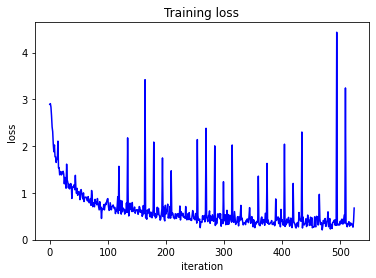

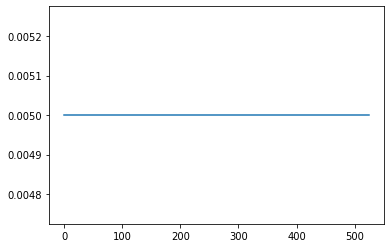

              precision    recall  f1-score   support

         0.0    0.96748   0.97541   0.97143       122
         1.0    0.93985   0.98425   0.96154       127
         2.0    0.93103   0.88525   0.90756       122
         3.0    0.95200   0.86861   0.90840       137
         4.0    0.88060   0.95935   0.91829       123
         5.0    0.84314   0.88660   0.86432        97
         6.0    0.92500   0.96522   0.94468       115
         7.0    0.94074   0.89437   0.91697       142
         8.0    0.95050   0.87273   0.90995       110
         9.0    0.86486   0.91429   0.88889       105

    accuracy                        0.92083      1200
   macro avg    0.91952   0.92061   0.91920      1200
weighted avg    0.92236   0.92083   0.92072      1200



In [241]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters(), lr=5e-3)

train(model, criterion, optimizer, x_train, y_train, epochs=35)
print(evaluate(model, x_test, y_test))

  3%|█▉                                                                  | 1/35 [00:00<00:12,  2.79it/s]

35.231267948064655


  6%|███▉                                                                | 2/35 [00:00<00:11,  2.77it/s]

38.397693086881404


  9%|█████▊                                                              | 3/35 [00:01<00:12,  2.65it/s]

37.3276425551512


 11%|███████▊                                                            | 4/35 [00:01<00:12,  2.56it/s]

36.42713814704613


 14%|█████████▋                                                          | 5/35 [00:01<00:11,  2.63it/s]

34.95570074241197


 17%|███████████▋                                                        | 6/35 [00:04<00:30,  1.07s/it]

33.986989589109825


 20%|█████████████▌                                                      | 7/35 [00:04<00:24,  1.16it/s]

32.98021902144898


 23%|███████████████▌                                                    | 8/35 [00:05<00:19,  1.42it/s]

32.491059367486635


 26%|█████████████████▍                                                  | 9/35 [00:05<00:15,  1.64it/s]

32.70583025690853


 29%|███████████████████▏                                               | 10/35 [00:05<00:13,  1.84it/s]

32.68768947012543


 31%|█████████████████████                                              | 11/35 [00:08<00:27,  1.15s/it]

33.106621573457694


 34%|██████████████████████▉                                            | 12/35 [00:08<00:21,  1.07it/s]

33.78876016498137


 37%|████████████████████████▉                                          | 13/35 [00:09<00:17,  1.27it/s]

34.20955727209427


 40%|██████████████████████████▊                                        | 14/35 [00:09<00:14,  1.49it/s]

34.146451590095666


 43%|████████████████████████████▋                                      | 15/35 [00:10<00:11,  1.70it/s]

34.322417631324576


 46%|██████████████████████████████▋                                    | 16/35 [00:12<00:21,  1.13s/it]

34.50258521608898


 49%|████████████████████████████████▌                                  | 17/35 [00:12<00:16,  1.09it/s]

34.802046102537474


 51%|██████████████████████████████████▍                                | 18/35 [00:13<00:12,  1.31it/s]

34.98860569067782


 54%|████████████████████████████████████▎                              | 19/35 [00:13<00:10,  1.46it/s]

34.86133461736511


 57%|██████████████████████████████████████▎                            | 20/35 [00:15<00:15,  1.02s/it]

34.91394125177936


 60%|████████████████████████████████████████▏                          | 21/35 [00:16<00:15,  1.11s/it]

35.5235061089684


 63%|██████████████████████████████████████████                         | 22/35 [00:17<00:12,  1.08it/s]

35.570821106659906


 66%|████████████████████████████████████████████                       | 23/35 [00:17<00:09,  1.30it/s]

35.66558358408228


 69%|█████████████████████████████████████████████▉                     | 24/35 [00:18<00:07,  1.53it/s]

36.067332417995786


 71%|███████████████████████████████████████████████▊                   | 25/35 [00:20<00:12,  1.25s/it]

36.05035952426412


 74%|█████████████████████████████████████████████████▊                 | 26/35 [00:21<00:08,  1.00it/s]

35.98579030206452


 77%|███████████████████████████████████████████████████▋               | 27/35 [00:21<00:06,  1.22it/s]

36.060041378635816


 80%|█████████████████████████████████████████████████████▌             | 28/35 [00:22<00:04,  1.45it/s]

36.20133926714691


 83%|███████████████████████████████████████████████████████▌           | 29/35 [00:22<00:03,  1.64it/s]

36.44996471762178


 86%|█████████████████████████████████████████████████████████▍         | 30/35 [00:24<00:05,  1.15s/it]

35.90883753239445


 89%|███████████████████████████████████████████████████████████▎       | 31/35 [00:25<00:03,  1.04it/s]

35.79167517704107


 91%|█████████████████████████████████████████████████████████████▎     | 32/35 [00:25<00:02,  1.26it/s]

35.73270635278831


 94%|███████████████████████████████████████████████████████████████▏   | 33/35 [00:26<00:01,  1.50it/s]

36.05049421999092


 97%|█████████████████████████████████████████████████████████████████  | 34/35 [00:26<00:00,  1.73it/s]

36.67016574725261


100%|███████████████████████████████████████████████████████████████████| 35/35 [00:28<00:00,  1.21it/s]

36.267138877930115


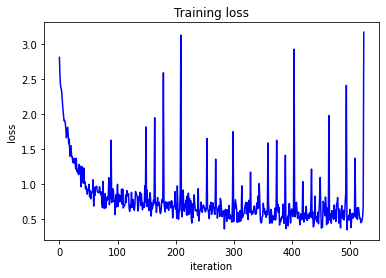

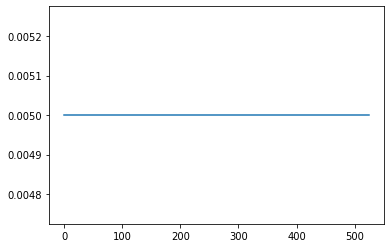

              precision    recall  f1-score   support

         0.0    0.90977   0.99180   0.94902       122
         1.0    0.91912   0.98425   0.95057       127
         2.0    0.95192   0.81148   0.87611       122
         3.0    0.97581   0.88321   0.92720       137
         4.0    0.85075   0.92683   0.88716       123
         5.0    0.88542   0.87629   0.88083        97
         6.0    0.89600   0.97391   0.93333       115
         7.0    0.93571   0.92254   0.92908       142
         8.0    0.95238   0.90909   0.93023       110
         9.0    0.89320   0.87619   0.88462       105

    accuracy                        0.91667      1200
   macro avg    0.91701   0.91556   0.91481      1200
weighted avg    0.91877   0.91667   0.91621      1200



In [242]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256, max_norm=(6, 2)),
    BatchNorm(256, max_norm=(32, 32)),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64, max_norm=(2, 1)),
    BatchNorm(64, max_norm=(16, 16)),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16, max_norm=(1, 0.2)),
    BatchNorm(16, max_norm=(8, 8)),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters(), lr=5e-3)

train(model, criterion, optimizer, x_train, y_train, epochs=35)
print(evaluate(model, x_test, y_test))

100%|███████████████████████████████████████████████████████████████████| 15/15 [02:28<00:00,  9.89s/it]


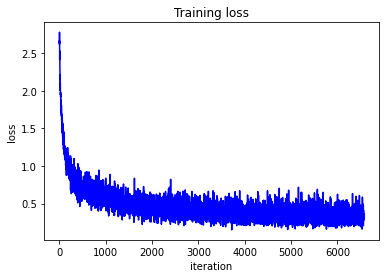

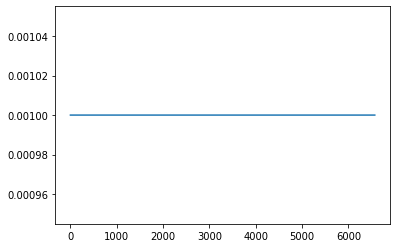

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1360
         1.0       0.99      0.98      0.98      1610
         2.0       0.98      0.98      0.98      1459
         3.0       0.98      0.97      0.98      1385
         4.0       0.99      0.98      0.98      1345
         5.0       0.98      0.97      0.97      1227
         6.0       0.98      0.99      0.98      1388
         7.0       0.97      0.98      0.98      1466
         8.0       0.96      0.97      0.97      1376
         9.0       0.97      0.97      0.97      1384

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [195]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=15)
print(evaluate(model, x_test, y_test))

100%|███████████████████████████████████████████████████████████████████| 15/15 [02:21<00:00,  9.41s/it]


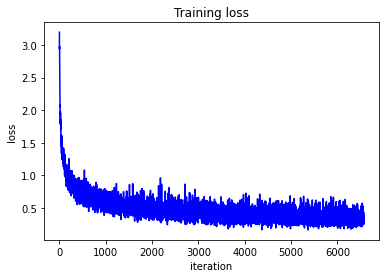

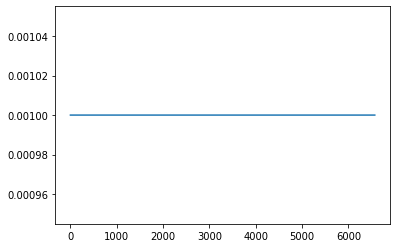

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1360
         1.0       0.98      0.99      0.98      1610
         2.0       0.97      0.98      0.97      1459
         3.0       0.98      0.96      0.97      1385
         4.0       0.97      0.98      0.98      1345
         5.0       0.97      0.97      0.97      1227
         6.0       0.99      0.98      0.99      1388
         7.0       0.98      0.97      0.97      1466
         8.0       0.96      0.97      0.97      1376
         9.0       0.96      0.96      0.96      1384

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



In [198]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=15)
print(evaluate(model, x_test, y_test))

100%|███████████████████████████████████████████████████████████████████| 50/50 [06:07<00:00,  7.36s/it]


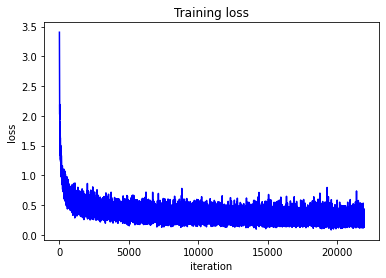

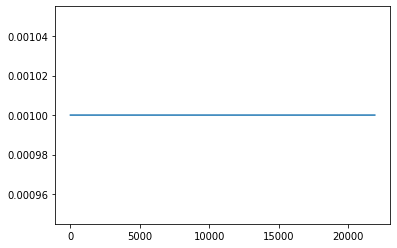

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1360
         1.0       0.99      0.99      0.99      1610
         2.0       0.97      0.98      0.98      1459
         3.0       0.98      0.97      0.98      1385
         4.0       0.99      0.98      0.99      1345
         5.0       0.98      0.98      0.98      1227
         6.0       0.99      0.99      0.99      1388
         7.0       0.98      0.98      0.98      1466
         8.0       0.98      0.97      0.97      1376
         9.0       0.97      0.97      0.97      1384

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [199]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters())

train(model, criterion, optimizer, x_train, y_train, epochs=50)
print(evaluate(model, x_test, y_test))

100%|███████████████████████████████████████████████████████████████████| 50/50 [08:00<00:00,  9.61s/it]


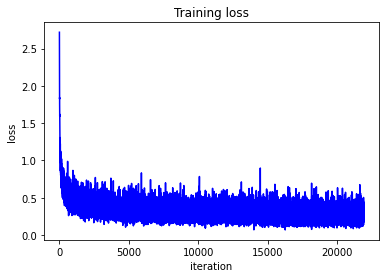

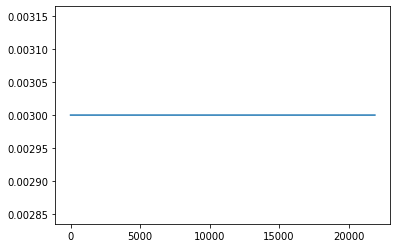

              precision    recall  f1-score   support

         0.0    0.99259   0.98456   0.98856      1360
         1.0    0.98398   0.99193   0.98794      1610
         2.0    0.97666   0.97533   0.97599      1459
         3.0    0.98754   0.97256   0.97999      1385
         4.0    0.98876   0.98067   0.98470      1345
         5.0    0.97557   0.97637   0.97597      1227
         6.0    0.97514   0.98919   0.98212      1388
         7.0    0.98218   0.97749   0.97983      1466
         8.0    0.96429   0.98110   0.97262      1376
         9.0    0.97388   0.96965   0.97176      1384

    accuracy                        0.98007     14000
   macro avg    0.98006   0.97988   0.97995     14000
weighted avg    0.98013   0.98007   0.98008     14000



In [203]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters(), lr=3e-3)

train(model, criterion, optimizer, x_train, y_train, epochs=50)
print(evaluate(model, x_test, y_test))

100%|███████████████████████████████████████████████████████████████████| 50/50 [07:34<00:00,  9.08s/it]


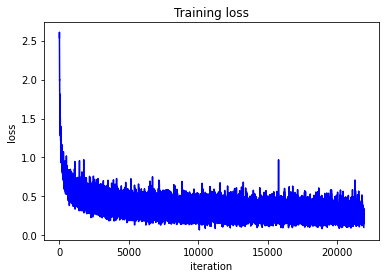

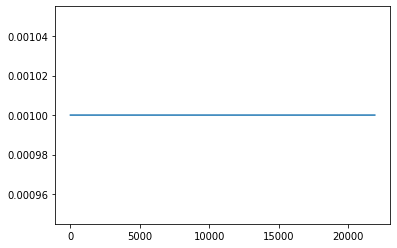

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1360
         1.0       0.98      0.99      0.99      1610
         2.0       0.98      0.98      0.98      1459
         3.0       0.97      0.98      0.98      1385
         4.0       0.99      0.98      0.99      1345
         5.0       0.98      0.97      0.98      1227
         6.0       0.99      0.99      0.99      1388
         7.0       0.98      0.98      0.98      1466
         8.0       0.98      0.97      0.98      1376
         9.0       0.98      0.97      0.97      1384

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [201]:
model = Sequential(
    Dropout(0.85),
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Dropout(0.6),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Dropout(0.6),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Dropout(0.6),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(model.parameters(), lr=3e-3)

train(model, criterion, optimizer, x_train, y_train, epochs=50)
print(evaluate(model, x_test, y_test))

### Try different learning rate schedulers

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.33s/it]


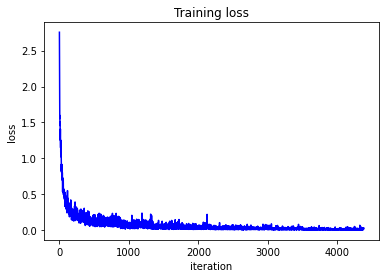

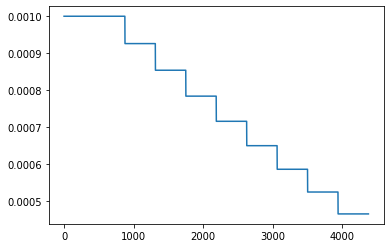

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1360
         1.0       0.99      0.99      0.99      1610
         2.0       0.98      0.98      0.98      1459
         3.0       0.97      0.97      0.97      1385
         4.0       0.99      0.98      0.98      1345
         5.0       0.97      0.97      0.97      1227
         6.0       0.98      0.99      0.98      1388
         7.0       0.98      0.98      0.98      1466
         8.0       0.97      0.97      0.97      1376
         9.0       0.98      0.97      0.97      1384

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [178]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = SGD(model.parameters())
scheduler = LinearDecay(optimizer, epochs=20, power=1.5)

train(model, criterion, optimizer, x_train, y_train, scheduler=scheduler, epochs=10)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.75s/it]


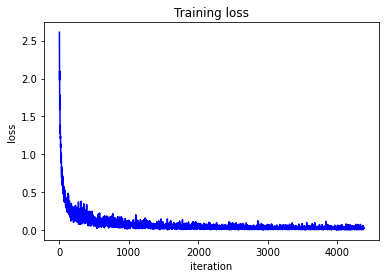

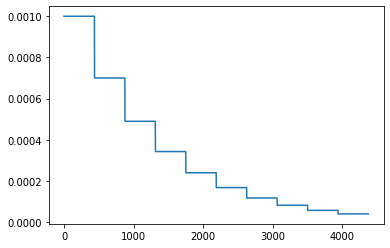

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1360
         1.0       0.99      0.99      0.99      1610
         2.0       0.96      0.98      0.97      1459
         3.0       0.98      0.97      0.97      1385
         4.0       0.98      0.98      0.98      1345
         5.0       0.97      0.96      0.97      1227
         6.0       0.98      0.98      0.98      1388
         7.0       0.98      0.98      0.98      1466
         8.0       0.96      0.97      0.97      1376
         9.0       0.97      0.97      0.97      1384

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [192]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = SGD(model.parameters())
scheduler = FactorDecay(optimizer, factor=0.7)

train(model, criterion, optimizer, x_train, y_train, scheduler=scheduler, epochs=10)
print(evaluate(model, x_test, y_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.25s/it]


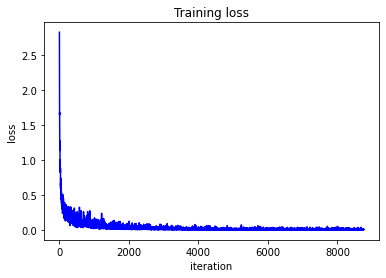

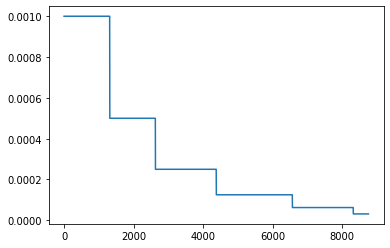

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1360
         1.0       0.99      0.99      0.99      1610
         2.0       0.98      0.97      0.98      1459
         3.0       0.98      0.97      0.98      1385
         4.0       0.98      0.97      0.98      1345
         5.0       0.97      0.97      0.97      1227
         6.0       0.98      0.99      0.98      1388
         7.0       0.97      0.98      0.98      1466
         8.0       0.97      0.97      0.97      1376
         9.0       0.97      0.97      0.97      1384

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [191]:
model = Sequential(
    Linear(784, 256),
    BatchNorm(256),
    ReLU(),
    Linear(256, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 16),
    BatchNorm(16),
    ReLU(),
    Linear(16, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = SGD(model.parameters())
scheduler = MultiFactorDecay(optimizer, times=[2, 5, 9, 14, 18])

train(model, criterion, optimizer, x_train, y_train, scheduler=scheduler, epochs=20)
print(evaluate(model, x_test, y_test))

In [200]:
%run hw_framework.ipynb

/home/ummagumma/.local/lib/python3.10/site-packages/IPython/core/magic.py:187: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 1.64 s, sys: 390 ms, total: 2.03 s
Wall time: 267 ms
CPU times: user 74.8 ms, sys: 10 ms, total: 84.9 ms
Wall time: 11 ms


(16,) (16, 784)


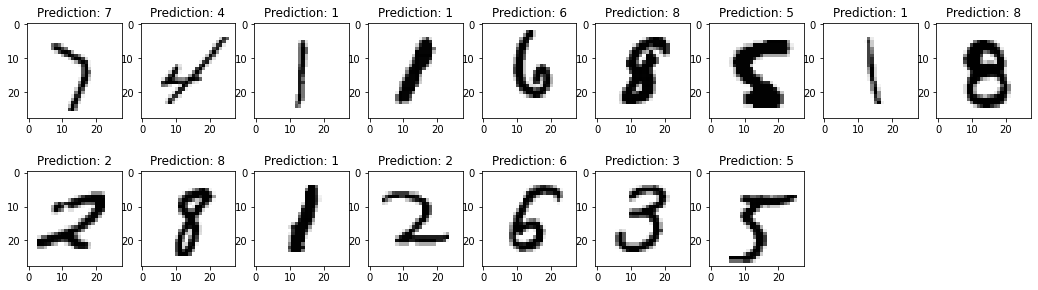

In [105]:
y_pred = []
x_ = []
for x, y in loader(x_test, y_test, 16):
    x_ = normalize_x(x)
    y_pred = model.forward(x_).argmax(axis=1)
    break
print(y_pred.shape, x_.shape)
x_ = x_ * 128 + 128
images_and_predictions = list(zip(x_,y_pred))

plt.figure(figsize=(18,5))
for index, (image, prediction) in enumerate(images_and_predictions[:19]):
    plt.subplot(2, 9, index + 1)
    image = image.reshape(28, 28)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

# save the figure
plt.savefig('plot3.png', dpi=300, bbox_inches='tight')

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

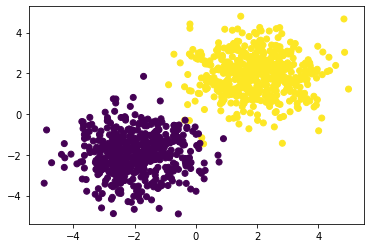

In [106]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [125]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = AdaDelta(model.parameters())

### Обучение

In [126]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

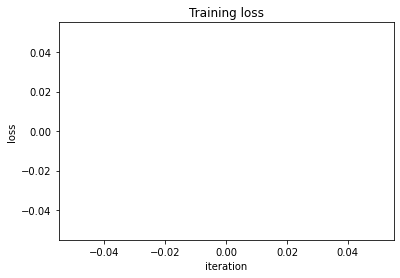

In [127]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        
        optimizer.step()
        # логгируем лосс
        # history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

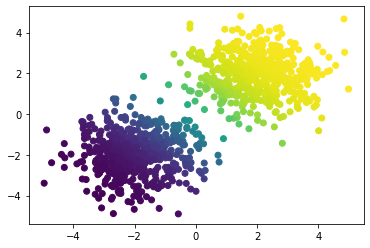

In [128]:
y_ = model.forward(X)

plt.scatter(X[:,0], X[:,1], c=y_[:,0])
plt.show()

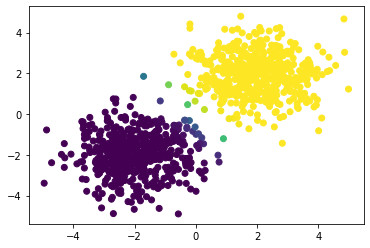

In [124]:
y_ = model.forward(X)

plt.scatter(X[:,0], X[:,1], c=y_[:,0])
plt.show()

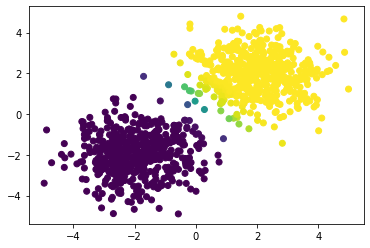

In [120]:
y_ = model.forward(X)

plt.scatter(X[:,0], X[:,1], c=y_[:,0])
plt.show()

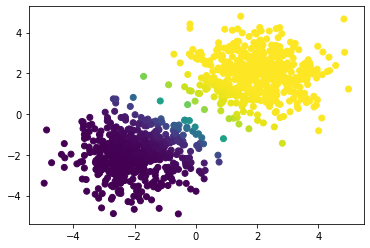

In [116]:
y_ = model.forward(X)

plt.scatter(X[:,0], X[:,1], c=y_[:,0])
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [154]:
import os
# dataset = fetch_openml(name='mnist_784')
X = dataset.data.to_numpy()
Y = dataset.target.to_numpy().astype(np.float64)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Переведите лейблы в one-hot.

In [150]:
def to_one_hot(x, n_classes):
    out = np.zeros((x.shape[0], n_classes))
    out[np.arange(x.shape[0]),x.astype(np.int32)] = 1
    return out

def normalize_x(x):
    return (x - 128) / 128

Разделите датасет на train и validation.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [155]:
def evaluate(model, X, Y):
    model.eval()
    trues = []
    preds = []    
    for x, y_true in loader(X, Y, batch_size):
        x_ = normalize_x(x)
        y_pred = model.forward(x_).argmax(axis=1)
        trues.extend(y_true)
        preds.extend(y_pred)
        
    return classification_report(trues, preds)

In [156]:
def train(model, criterion, optimizer, X, Y, 
          epochs = 5,
          batch_size = 128,
          learning_rate = 1e-3):
    history = []
    grads = []
    grad_means_l = []

    for i in tqdm(range(epochs)):
        for x, y_true in loader(X, Y, batch_size):

            x_ = normalize_x(x)
            y_true_oh = to_one_hot(y_true, 10)
            y_pred = model.forward(x_)
            loss = criterion.forward(y_pred, y_true_oh)

            grad = criterion.backward(y_pred, y_true_oh)
            model.backward(x_, grad)
            
#             g = clip_grad(model.grad_parameters(), 1.0)
#             grads.append(g)
            grad_means_l.append(grad_means(model.grad_parameters()))

            # обновляем веса
            optimizer.step()

            history.append(loss)

    plt.title("Training loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.plot(history, 'b')
    plt.show()
    
#     plt.title("Gradient mean")
#     plt.xlabel("iteration")
#     plt.ylabel("grad mean")
#     plt.plot(grads, 'b')
#     plt.show()
    
#     plt.plot(grad_means_l)
#     plt.show()